<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
"""
@author: LorenzoVisentini
"""

#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#keras
import keras
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#inception v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [23]:
#Images parameters
img_width = 299
img_height = 299

# train_dir = './source_light/training'
# validation_dir = './source_light/validation' 
train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/source_light/training'
validation_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/source_light/validation' 


In [24]:
#from https://edebrouwer.github.io/deeplearning/carvision/transfer/neural/networks/learning/2017/08/05/TransferLearning.html

#Transfer learning on InceptionV3 model
#use all the layers except for the last fully connected layer (because its 
#specific to the ImageNet competition)
#we will retrain layers with new inputs
pre_trained_model = InceptionV3(input_shape = (img_height, img_width, 3),
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check V3 structure

In [25]:
n_classes = 3

#transfer learning phase
x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation= 'relu')(x) #add fully connected layer
x = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = x)

#freeze the model excepted added layers
#freeze the model excepted added layers
for layer in pre_trained_model.layers:
    layer.trainable = False

model.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [26]:
#preprocessing
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=64,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(directory=validation_dir,
                                                    target_size=(img_height, img_width),
                                                    color_mode="rgb",
                                                    batch_size=64,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

Found 7000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [27]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//train_generator.batch_size,
                             epochs = 10,
                             validation_data = val_generator
                             )


Epoch 1/10
109/109 [==============================] - 126s 1s/step - loss: 1.0529 - accuracy: 0.5288 - val_loss: 1.0104 - val_accuracy: 0.5353
Epoch 2/10
109/109 [==============================] - 112s 1s/step - loss: 0.8361 - accuracy: 0.5959 - val_loss: 0.7854 - val_accuracy: 0.5753
Epoch 3/10
109/109 [==============================] - 112s 1s/step - loss: 0.8003 - accuracy: 0.6126 - val_loss: 0.9291 - val_accuracy: 0.5573
Epoch 4/10
109/109 [==============================] - 112s 1s/step - loss: 0.7753 - accuracy: 0.6311 - val_loss: 0.8862 - val_accuracy: 0.5513
Epoch 5/10
109/109 [==============================] - 112s 1s/step - loss: 0.7732 - accuracy: 0.6322 - val_loss: 1.2378 - val_accuracy: 0.5493
Epoch 6/10
109/109 [==============================] - 112s 1s/step - loss: 0.7502 - accuracy: 0.6482 - val_loss: 1.1680 - val_accuracy: 0.5620
Epoch 7/10
109/109 [==============================] - 112s 1s/step - loss: 0.7358 - accuracy: 0.6609 - val_loss: 0.8588 - val_accuracy: 0.5740

In [28]:
import pickle
#save model and history
model.save('/content/drive/My Drive/Deep Learning Project - Image Classification/Models/InceptionV3_batch64epoch10.h5')

with open('/content/drive/My Drive/Deep Learning Project - Image Classification/History/InceptionV3_batch64epoch10.csv', 'wb') as file:
    pickle.dump(history.history, file)


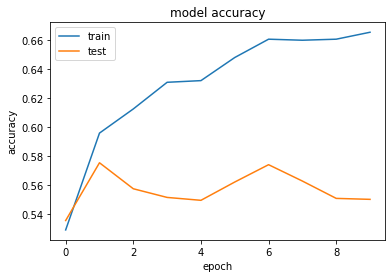

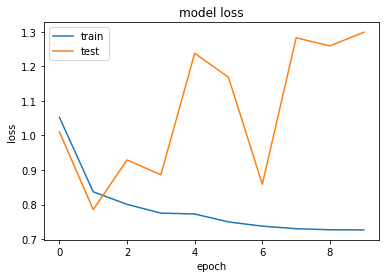

In [29]:
#plot results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
#evaluation
# https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict
steps = val_generator.n // val_generator.batch_size

accuracy_ontest = model.evaluate_generator(val_generator, steps)
predictions_ontest = model.predict_generator(val_generator, steps)
print(accuracy_ontest)
print(predictions_ontest)

[1.3282110691070557, 0.55027174949646]
[[0.9427286  0.0141655  0.04310593]
 [0.50951016 0.21751173 0.27297807]
 [0.7904144  0.05229604 0.15728952]
 ...
 [0.57545555 0.20999745 0.214547  ]
 [0.9706325  0.00793954 0.02142794]
 [0.9089068  0.02032491 0.07076833]]
